In [1]:
print("sairam")

sairam


Context
This dataset is a collection of datasets from different sources related to the automatic detection of cyber-bullying. The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages and YouTube. The data contain text and labeled as bullying or not. The data contains different types of cyber-bullying like hate speech, aggression, insults and toxicity.

Content
The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages and YouTube. The data contain text and labeled as bullying or not. The data contains different types of cyber-bullying like hate speech, aggression, insults and toxicity.

We are concerned about dataset from twitter alone

Import the required libraries

In [10]:
#Data pre-processing
import pandas as pd
import numpy as np

#Text related
import re
import string
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
from textblob import TextBlob
nltk.download('omw-1.4')
from nltk import sent_tokenize
from gensim.utils import simple_preprocess


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

#Pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

#Imputer
# import the KNNimputer class
from sklearn.impute import KNNImputer

#Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

#W2v
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

#ANN
import tensorflow as tf 
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

#Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score

#Oversampling
from imblearn.over_sampling import SMOTE

#Misc
from collections import Counter
import tqdm

pd.set_option('display.max_rows', 250)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2.10.0


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SAIRAM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Import the dataset

In [11]:
data = pd.read_csv('twitter_parsed_dataset.csv')
print("Number of data points", data.shape[0])
print(f"Number of features    {data.shape[1]}")
data.head()

Number of data points 16851
Number of features    5


,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [12]:
data['Text'].sample(1).values[0]

'Wow, four rounds of instant restaurants. They know people will tune out when the second phase begins. How long will this go? #mkr'

Exploratory data analysis

* Target variable

In [13]:
data['oh_label'].value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [14]:
x = list(data['oh_label'].unique())
type(x[2])


numpy.float64

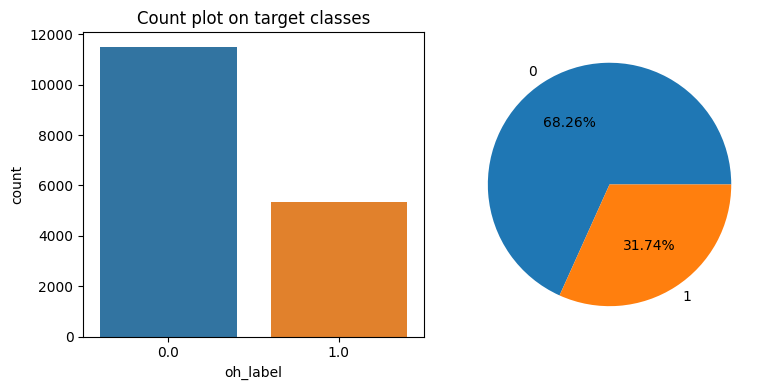

In [15]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.countplot(x=data['oh_label'])
plt.title('Count plot on target classes')

plt.subplot(1,2,2)
plt.pie(x=data['oh_label'].value_counts(sort=False), labels=[0,1], autopct='%1.2f%%')

plt.tight_layout()

* Slightly imbalanced dataset

Data cleaning

In [16]:
data.isnull().mean()

index         0.000000
id            0.000059
Text          0.000059
Annotation    0.000178
oh_label      0.000178
dtype: float64

In [17]:
data[data['oh_label'].isna()]

,index,id,Text,Annotation,oh_label
2992,5.67909969783169E+017,5.67909969783169E+017,RT @Lizzethismetal: Probably gonna piss off so...,NaN,NaN
2993,#yesallmen,NaN,NaN,NaN,NaN
2994,@MT8_9 http://t.co/QHo6dhumjc,sexism,1,NaN,NaN


In [18]:
data.dropna(axis=0, inplace=True)
print(data.shape)

(16848, 5)


In [19]:
data[data['oh_label'].isna()]

,index,id,Text,Annotation,oh_label


* Very few missing values and they are removed from the dataset

In [20]:
def lower_text(text):
    sample = text
    sample = ' '.join([word.lower() for word in sample.split()])
    
    return sample

'''
\S - Non white space character
* - ab* ==> a,ab, abb (a followed by any number of b's)
? - ab? ==> repeation of 1 time only -a,ab  | https? == https and http both will be detected
Idea - non white space characters having http or https will be detected and substitued
'''
def remove_url(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", '', sample)
    return sample

# *? - adding ? makes the function non-greedy
# <.*?> - any characters enclosed between < and > & </
def remove_html(text):
    sample = text
    sample = re.sub("<.*?>", '', sample)
    return sample

def remove_punctuation(text):
    print('remove_punctuation:', text)
    sample = text
    sample = re.sub('\[.*?\]', '', sample)
    
    sample = re.sub('\(.*?\)', '', sample)
    
    sample = re.sub('[%s]' %re.escape('!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'), '', sample)  #removed full stop from string.punctuation. Because words preceding the full stop are getting lost
    print('1', sample)
    sample = re.sub('[.]', ' ', sample)
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    return sample

def remove_hashtag_total(text):
    print('remove_hashtag_total')
    sample = text
    sample = re.sub('#', '', sample)
    return sample

def remove_hashtags_at_start(text):
    print('remove_hashtags_at_start')
    sample = ' '.join([word for word in text.split() if not word.startswith('#')])
    return sample

def remove_emojis(text):
    sample = text
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    return sample

#wordpunct_tokenize: splits the special characters like aposthephies also a separate word
#word_tokenize: works using regex - gets rid off the special characters
only_english_words = nltk.corpus.words.words()
def remove_special_characters(text):
    print('remove special character')
    print('Text:', text)
    sample = text
    sample = re.sub('\n', '', sample)  #New line character
    sample = re.sub('\\n', '', sample) #New line character
    sample = ' '.join([word for word in nltk.word_tokenize(sample) if word.lower() in only_english_words or not word.isalpha() 
                                                                   or word.lower()[:-1] in only_english_words]) #Filter only the english characters
    sample = ' '.join(list(filter(lambda ele: re.search("[A-Za-z\s]", ele) is not None, sample.split()))) #Non english words will be filtered
    sample = ' '.join([x.strip() for x in sample.split()])  #To trim the white space characters before and at the end of the sentences
    print('remove spl charac:', sample)
    return sample

    

In [21]:
text0 = remove_html(data['Text'][0])
text0 = 'Feeling so sorry for the girls'

temp = remove_url(text0)
print(temp)

temp = remove_html(temp)
print(temp)

temp = remove_punctuation(temp)
print(temp)

temp = remove_hashtag_total(temp)
print(temp)

temp = remove_hashtags_at_start(temp)
print(temp)

print(temp)
temp = remove_special_characters(temp)
print(temp)

temp = remove_emojis(temp)
print(temp)

print('**')
print(temp)

Feeling so sorry for the girls
Feeling so sorry for the girls
remove_punctuation: Feeling so sorry for the girls
1 Feeling so sorry for the girls
Feeling so sorry for the girls
remove_hashtag_total
Feeling so sorry for the girls
remove_hashtags_at_start
Feeling so sorry for the girls
Feeling so sorry for the girls
remove special character
Text: Feeling so sorry for the girls
remove spl charac: Feeling so sorry for the girls
Feeling so sorry for the girls
Feeling so sorry for the girls
**
Feeling so sorry for the girls


In [22]:
w = 'girls' 
w[:-1] in only_english_words

True

In [23]:
w[:-1]

'girl'

In [24]:
'girl' in only_english_words

True

Compiled all the cleaning functions together

In [25]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' %re.escape('!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'), '', sample)  #removed full stop from string.punctuation. Because words preceding the full stop are getting lost
    sample = re.sub('[.]', ' ', sample)
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()
                                                                  or w.lower()[:-1] in only_english_words]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [26]:
data['cleaned_text'] = data['Text'].apply(lambda x: clean_text(x))

In [27]:
data[['Text', 'cleaned_text']]

,Text,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",rt call me but when i go to an auto place id r...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",wrong follows the example of and the exactly
4,#mkr No No No No No No,no no no no no no
...,...,...
16846,"Feeling so sorry for the girls, they should be...",feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,pretty good were happy with ok well im never e...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,rt lemon tart can we please go just one season...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,you are too stupid to talk to blocked


### Text word-wise cleaning

**stop words**  

Stop words are available in abundance in any human language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information. In order words, we can say that the removal of such words does not show any negative consequences on the model we train for our task.
Removal of stop words definitely reduces the dataset size and thus reduces the training time due to the fewer number of tokens involved in the training.  

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.  

**parts-of-speech-tagging**

<code>from nltk.corpus import wordnet
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
</code>


  
    

**stemming vs lemmatizing**  

Stemming and Lemmatization are text normalization techniques.  

Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.
Often when searching text for a certain keyword, it helps if the search returns variations of the word. For instance, searching for “boat” might also return “boats” and “boating”. Here, “boat” would be the stem for [boat, boater, boating, boats].   

In contrast to stemming, lemmatization looks beyond word reduction and considers a language’s full vocabulary to apply a morphological analysis to words. The lemma of ‘was’ is ‘be’ and the lemma of ‘mice’ is ‘mouse’.
Lemmatization is typically seen as much more informative than simple stemming, which is why Spacy has opted to only have Lemmatization available instead of Stemming

>Stemming and Lemmatization both generate the foundation sort of the inflected words and therefore the only difference is that stem may not be an actual word whereas, lemma is an actual language word.
Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used a corpus also to supply lemma which makes it slower than stemming. you furthermore might had to define a parts-of-speech to get the proper lemma.

boys were playing

boy were play  
boys be play

In [28]:
stop_words = list(stopwords.words('english'))
'not' in stop_words
print(len(stop_words))
stop_words.remove('not')
print(len(stop_words))

def remove_stop_words(text):
    sample = text
    sample = ' '.join([word for word in sample.split() if word not in stop_words])
    return sample

ps = PorterStemmer()
def stem_words(text):
    sample = text
    sample = ' '.join([ps.stem(word) for word in sample.split()])
    return sample

def correct_spell(text):
    sample = temp
    sample = str(TextBlob(sample).correct())
    return sample

#Get POS tag of the word
def get_wordnet_pos(word):
    #print('pos:', word)
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN   #Lemmatizer throwing error with empty pos is passed - as per nltk lemmatizer document, default pos is N

lemma = WordNetLemmatizer()
def lemmatize_words(text):
    sample = text
    sample = ' '.join([lemma.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample.split()])
    return sample

179
178


In [29]:
stop_words = list(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
print(len(stop_words))

def process_words(text, stop_words_flag=True, Stem_flag=False, Lemma_flag=False, spell_check_flag=False):
    if Stem_flag and Lemma_flag:
        return('Error! Cannot do stemming & lemmatizing together')
    
    if stop_words_flag:
        sample = text.lower()
        sample = ' '.join([word for word in sample.split() if word not in stop_words])
        print(sample)
    
    if Stem_flag:
        print('stemming on')
        ps = PorterStemmer()
        sample = ' '.join([ps.stem(word) for word in sample.split()])
        return sample
    
    if Lemma_flag:
        lemma = WordNetLemmatizer()
        print('Lemma on')
        sample = ' '.join([lemma.lemmatize(word) for word in sample.split()])
        return sample
    
    if spell_check_flag:
        sample = str(TextBlob(sample).correct())
        return sample

177


In [30]:
data['corrected_text'] = data['cleaned_text'].apply(lambda x: process_words(x, stop_words_flag=True, Stem_flag=False, Lemma_flag=True, spell_check_flag=True))

read context no change meaning history slavery
Lemma on
shreyabafna3 idiots claim people tried stop becoming terrorist made terrorist brain dead
Lemma on
rt call go auto place id rather talk guy
Lemma on
wrong follows example exactly
Lemma on
no no no no no no
Lemma on
rt preacher raped tortured five daughter death released
Lemma on
rt not bad drivers
Lemma on
going make pancakes dont bananas
Lemma on
rt dare feelings fantastic way dehumanize someone
Lemma on
rt theres something wrong girl wins street striker
Lemma on
shes not dont run blocking manually
Lemma on
good good despite bad religion not
Lemma on
help everyone asks im not pass judgment anyone comes looking help
Lemma on
yeah human life idiot something genocidal wouldnt understand
Lemma on
eventually like wait harper youre randi harper still dont know adjust
Lemma on
delusion factory running full speed trolls
Lemma on
rt kat amp river amp chance save one type sandwich would
Lemma on
rt literally site today
Lemma on
juxtapositio

In [31]:
data[['Text', 'cleaned_text', 'corrected_text']]

,Text,cleaned_text,corrected_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,i read them in context no change in meaning th...,read context no change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...,shreyabafna3 idiot claim people tried stop bec...
2,"RT @Mooseoftorment Call me sexist, but when I ...",rt call me but when i go to an auto place id r...,rt call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",wrong follows the example of and the exactly,wrong follows example exactly
4,#mkr No No No No No No,no no no no no no,no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",feeling so sorry for the girls they should be ...,feeling sorry girl safe kat going home
16847,#MKR 'pretty good dishes we're happy with' - O...,pretty good were happy with ok well im never e...,pretty good happy ok well im never eating place
16848,RT @colonelkickhead: Deconstructed lemon tart!...,rt lemon tart can we please go just one season...,rt lemon tart please go one season without som...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,you are too stupid to talk to blocked,stupid talk blocked


Feature extraction & EDA

In [32]:
data_copy = data.copy(deep=True)

In [33]:
data['word_count'] = data['corrected_text'].apply(lambda x:len(x.split(' ')))
data[['corrected_text','word_count']].head()

,corrected_text,word_count
0,read context no change meaning history slavery,7
1,shreyabafna3 idiot claim people tried stop bec...,12
2,rt call go auto place id rather talk guy,9
3,wrong follows example exactly,4
4,no no no no no no,6


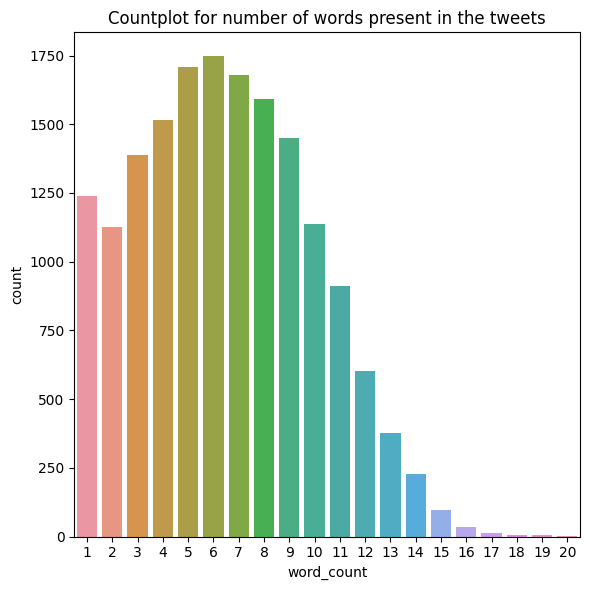

In [34]:
plt.figure(figsize=(6,6))
sns.countplot(x=data['word_count'].sort_values())
plt.title('Countplot for number of words present in the tweets')
plt.tight_layout()

- Tweets with 6,5,7 words are more in the corpus
- No tweets with 0 words 
- Very less tweets with more words > 16

In [35]:
data['char_count'] = data['corrected_text'].str.len()
print(data['char_count'].nunique())

110


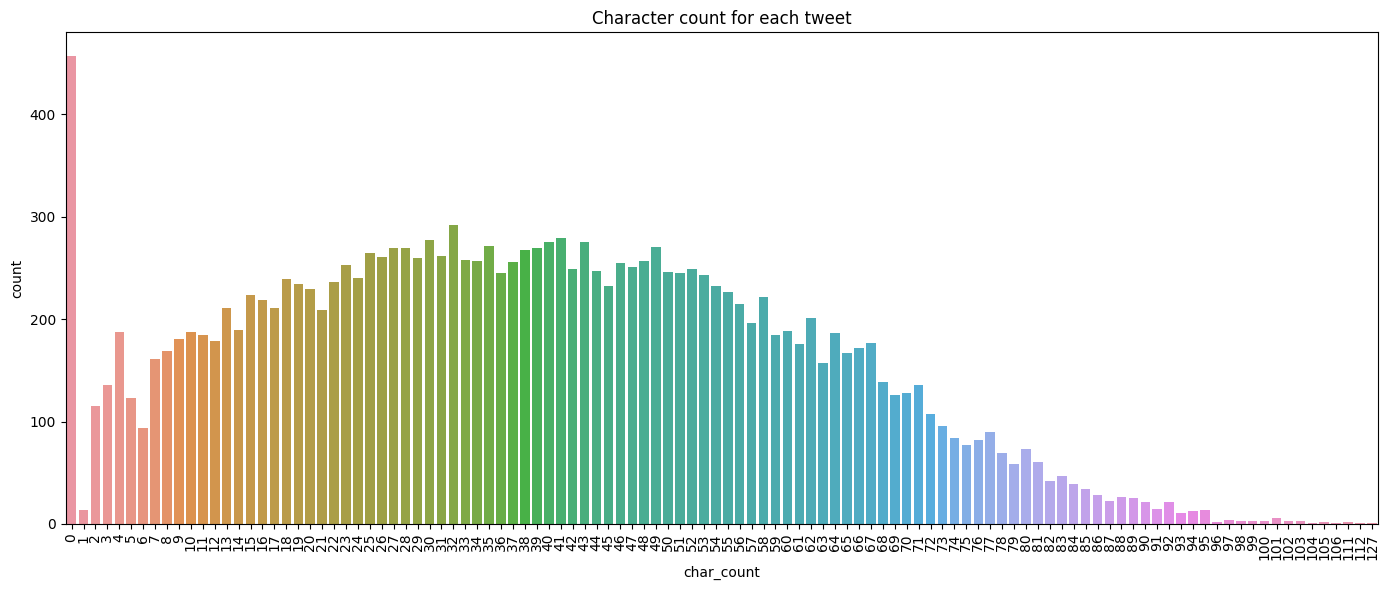

In [36]:
plt.figure(figsize=(14,6))
sns.countplot(x=data['char_count'].sort_values())
plt.title('Character count for each tweet')
plt.xticks(rotation=90)
plt.tight_layout()

- Most of the tweets are with character count between 25 and 50
- 0 characters are noticed - Need to check further

<AxesSubplot: >

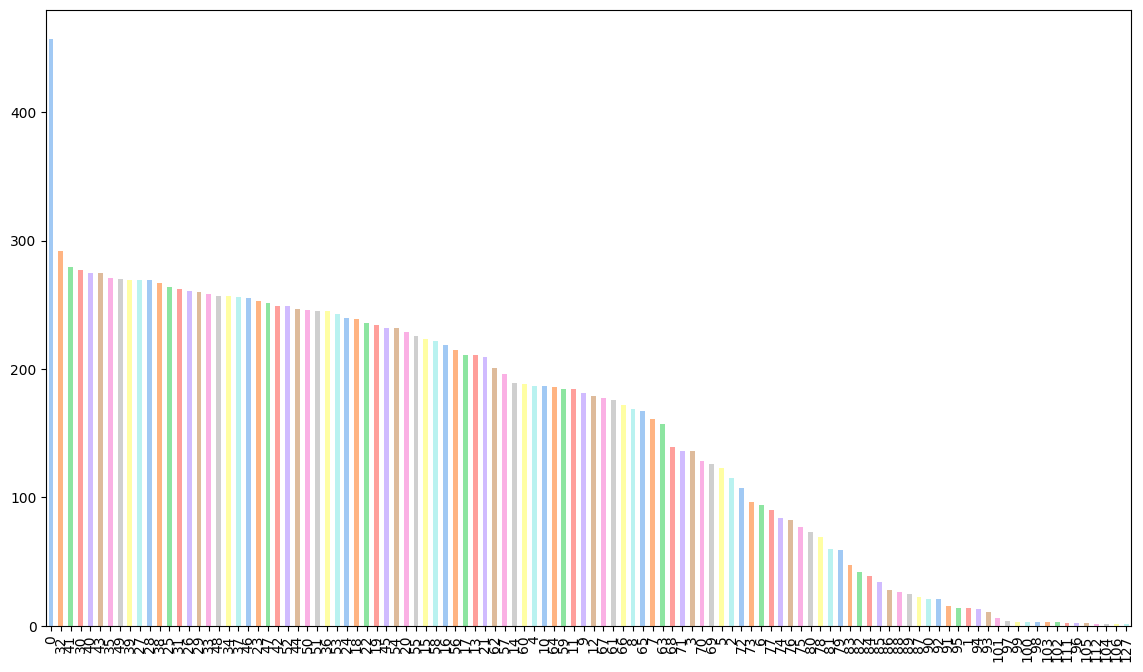

In [37]:
plt.figure(figsize=(14,8))
data['char_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('pastel'))

In [38]:
data[data['char_count'] == 0]

,index,id,Text,Annotation,oh_label,cleaned_text,corrected_text,word_count,char_count
88,5.76470520247489E+017,5.76470520247489E+017,@mistertodd yessssss.,none,0.0,,,1,0
179,5.7661373828488E+017,5.7661373828488E+017,@dankmtl @PeaceNotHate_ http://t.co/HxgNJvWoqG,none,0.0,,,1,0
211,5.75686201488712E+017,5.75686201488712E+017,@Assiye61 http://t.co/dduX3ZbMtE,none,0.0,,,1,0
230,5.75596220036555E+017,5.75596220036555E+017,Ughhhh #MKR,none,0.0,,,1,0
256,5.64178484721762E+017,5.64178484721762E+017,@MaDaSaHaTtEr_17 @buttercupashby http://t.co/P...,none,0.0,,,1,0
...,...,...,...,...,...,...,...,...,...
16665,5.75597267735876E+017,5.75597267735876E+017,#mkr #katmkr http://t.co/vLYkzY5p7D,none,0.0,,,1,0
16717,5.5271923546692E+017,5.5271923546692E+017,@ISIS_Med ROFLMAO.,none,0.0,,,1,0
16719,5.71890755192549E+017,5.71890755192549E+017,@iAmCaticorn @CherguiaMbark http://t.co/igBq14...,none,0.0,,,1,0
16771,5.51759665370247E+017,5.51759665370247E+017,@ROJNAME_english http://t.co/Ej5MsCentH,none,0.0,,,1,0


After cleaning, few of tweets are completely lost - drop these records

In [39]:
print(data.shape)
data = data[data['char_count'] > 0]
print(data.shape)

(16848, 9)
(16391, 9)


Calculate the averga character count in each tweet

In [40]:
def average_char_count(text):
    sample = text
    
    return np.round(sum((len(word)) for word in sample.split())/len([word for word in sample.split()]), 2)

In [41]:
data['avg_word_length'] = data['corrected_text'].apply(lambda x: average_char_count(x))
data[['corrected_text', 'word_count', 'avg_word_length']]

,corrected_text,word_count,avg_word_length
0,read context no change meaning history slavery,7,5.71
1,shreyabafna3 idiot claim people tried stop bec...,12,6.33
2,rt call go auto place id rather talk guy,9,3.56
3,wrong follows example exactly,4,6.50
4,no no no no no no,6,2.00
...,...,...,...
16846,feeling sorry girl safe kat going home,7,4.57
16847,pretty good happy ok well im never eating place,9,4.33
16848,rt lemon tart please go one season without som...,11,5.27
16849,stupid talk blocked,3,5.67


In [42]:
data.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label', 'cleaned_text',
       'corrected_text', 'word_count', 'char_count', 'avg_word_length'],
      dtype='object')

In [70]:
final_data = data[['corrected_text', 'word_count', 'char_count','avg_word_length', 'oh_label']]
final_data.head()

,corrected_text,word_count,char_count,avg_word_length,oh_label
0,read context no change meaning history slavery,7,46,5.71,0.0
1,shreyabafna3 idiot claim people tried stop bec...,12,87,6.33,0.0
2,rt call go auto place id rather talk guy,9,40,3.56,1.0
3,wrong follows example exactly,4,29,6.50,1.0
4,no no no no no no,6,17,2.00,0.0


Wordcloud

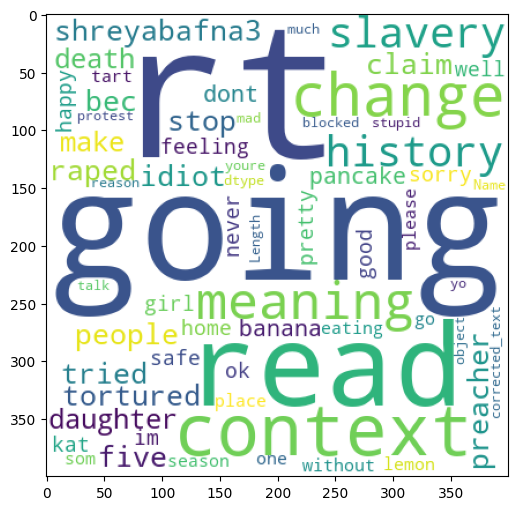

In [71]:
#Positive tweets

g = str(final_data[final_data['oh_label'] == 0]['corrected_text'])

wc = WordCloud(background_color='white', height=400, width=400, min_font_size=5).generate(g)

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.show()

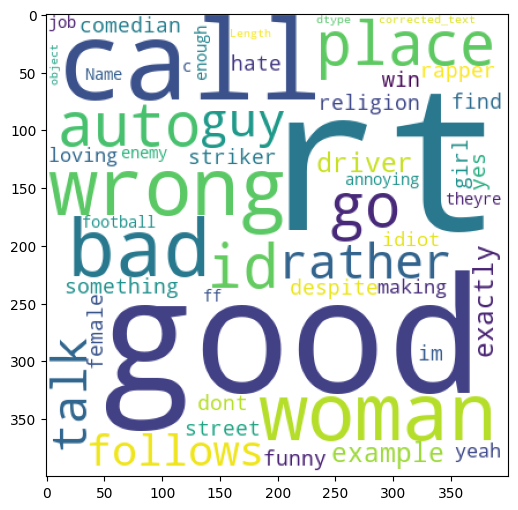

In [72]:
#Negative tweets

g = str(final_data[final_data['oh_label'] ==1 ]['corrected_text'])

wc = WordCloud(background_color='white', height=400, width=400, min_font_size=5).generate(g)

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.show()

* Feel more pre-processing is needed - Negative word cloud has few positive words and vice - versa 
* could be they are negated in the sentence and not captured in the word cloud
* However model evaluation can help to understand if pre-processing is okay or needed more

Independent & dependent features

In [73]:
X = final_data.drop('oh_label', axis=1)
Y = final_data['oh_label']

print(X.shape, Y.shape)

(16391, 4) (16391,)


Train-Test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1702)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print('\n')
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(11473, 4) (11473,)
(4918, 4) (4918,)


0.0    0.672448
1.0    0.327552
Name: oh_label, dtype: float64
0.0    0.681781
1.0    0.318219
Name: oh_label, dtype: float64


In [75]:
y_train.reset_index(drop=True)

0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
11468    0.0
11469    1.0
11470    1.0
11471    0.0
11472    0.0
Name: oh_label, Length: 11473, dtype: float64

In [76]:
X_train.reset_index(drop=True)

,corrected_text,word_count,char_count,avg_word_length
0,legal right every western nation privileged,6,43,6.33
1,rt dont know youre read female comedian enjoy,8,45,4.75
2,literally going laundry list heavily every one,7,46,5.71
3,indeed,1,6,6.00
4,know know intent prove dont know,6,32,4.50
...,...,...,...,...
11468,huge still idiot like waste men like dirt,8,41,4.25
11469,rt beware con artist coopt feminism dont expec...,12,73,5.17
11470,clever tweet think wear driving look rear mirr...,9,61,5.89
11471,sterile,1,7,7.00


# Modelling

Bag of words

In [77]:
Z_train = X_train[['word_count', 'char_count','avg_word_length']]
X_train.drop(['word_count', 'char_count','avg_word_length'], axis=1, inplace=True)

Z_test = X_test[['word_count', 'char_count','avg_word_length']]
X_test.drop(['word_count', 'char_count','avg_word_length'], axis=1, inplace=True)

X_train.head()

,corrected_text
3156,legal right every western nation privileged
2506,rt dont know youre read female comedian enjoy
1117,literally going laundry list heavily every one
10064,indeed
3724,know know intent prove dont know


In [78]:
bow = CountVectorizer(max_features=500)
X_train_vect = bow.fit_transform(X_train['corrected_text'])
X_test_vect = bow.transform(X_test['corrected_text'])

print(X_train_vect.shape, X_test_vect.shape)

(11473, 500) (4918, 500)


In [79]:
X_train_vect = pd.DataFrame(X_train_vect.toarray(),columns=bow.get_feature_names())
X_test_vect = pd.DataFrame(X_test_vect.toarray(),columns=bow.get_feature_names())

In [80]:
X_train_vect.head()

,able,absolutely,abuse,account,actually,ago,agree,alima,already,also,...,would,wouldnt,wow,wrong,yeah,year,yes,yet,youre,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
X_test_vect.head()

,able,absolutely,abuse,account,actually,ago,agree,alima,already,also,...,would,wouldnt,wow,wrong,yeah,year,yes,yet,youre,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
X_train_final = pd.concat([X_train_vect, Z_train.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_vect, Z_test.reset_index(drop=True)], axis=1)

X_train_final.head()

,able,absolutely,abuse,account,actually,ago,agree,alima,already,also,...,wrong,yeah,year,yes,yet,youre,zero,word_count,char_count,avg_word_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,43,6.33
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,8,45,4.75
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,46,5.71
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6,6.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,32,4.50


In [83]:
X_test_final.head()

,able,absolutely,abuse,account,actually,ago,agree,alima,already,also,...,wrong,yeah,year,yes,yet,youre,zero,word_count,char_count,avg_word_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,69,6.78
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,38,5.50
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,51,5.50
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,18,5.33
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,32,3.71


Function to try various models

In [84]:

def fit_model(X_train, y_train, X_test, y_test, **kwargs):
    
    scores = {}
    
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb_model = XGBClassifier()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        
        print(f"XGB: Train score {accuracy_score(y_train, xgb_model.predict(X_train))}")
        print(f"XGB: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"XGB: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")        
        print(confusion_matrix(y_test, y_pred))
        
        print_metrics(y_test, y_pred)
        
        print('\n')
        
        scores['xgb'] = accuracy_score(y_test, y_pred)
        
    if 'gbm' in kwargs.keys() and kwargs['gbm']:
        gbm_model = GradientBoostingClassifier()
        gbm_model.fit(X_train, y_train)
        y_pred = gbm_model.predict(X_test)
        
        print(f"GBM: Train score {accuracy_score(y_train, gbm_model.predict(X_train))}")
        print(f"GBM: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"GBM: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")
        print(confusion_matrix(y_test, y_pred))
        print('\n')
        
        print_metrics(y_test, y_pred)
        
        scores['GBM'] = accuracy_score(y_test, y_pred)
        
    if 'logistic' in kwargs.keys() and kwargs['logistic']:
        log_model = LogisticRegression()
        log_model.fit(X_train, y_train)
        y_pred = log_model.predict(X_test)
        
        print(f"Log: Train score {accuracy_score(y_train, log_model.predict(X_train))}")
        print(f"Log: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"Log: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")        
        print(confusion_matrix(y_test, y_pred))
        print('\n')
        
        print_metrics(y_test, y_pred)
        
        scores['logistic'] = accuracy_score(y_test, y_pred)    
        
        
    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf_model = RandomForestClassifier()
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        print(f"RF: Train score {accuracy_score(y_train, rf_model.predict(X_train))}")
        print(f"RF: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"RF: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")        
        print(confusion_matrix(y_test, y_pred))
        print('\n')
        
        print_metrics(y_test, y_pred)
        
        scores['rf'] = accuracy_score(y_test, y_pred)      
        
    if 'etc' in kwargs.keys() and kwargs['etc']:
        etc_model = RandomForestClassifier()
        etc_model.fit(X_train, y_train)
        y_pred = etc_model.predict(X_test)
        
        print(f"ETC: Train score {accuracy_score(y_train, etc_model.predict(X_train))}")
        print(f"ETC: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"ETC: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")        
        print(confusion_matrix(y_test, y_pred))
        print('\n')
        
        print_metrics(y_test, y_pred)
        
        scores['etc'] = accuracy_score(y_test, y_pred)            
        
    if 'mnb' in kwargs.keys() and kwargs['mnb']:
        mnb_model = MultinomialNB()
        mnb_model.fit(X_train, y_train)
        y_pred = mnb_model.predict(X_test)
        
        print(f"MNB: Train score {accuracy_score(y_train, mnb_model.predict(X_train))}")
        print(f"MNB: Test  score {accuracy_score(y_test, y_pred)}")
        print(f"MNB: F1    score {f1_score(y_test, y_pred, average='weighted')}")
        print(f"Precision {precision_score(y_test, y_pred)}")
        print(f"Recall {recall_score(y_test, y_pred)}")        
        print(confusion_matrix(y_test, y_pred))
        print('\n')
        
        print_metrics(y_test, y_pred)
        
        scores['MNB'] = accuracy_score(y_test, y_pred)            
        
    return scores  


def print_metrics(y_test, y_pred):
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)
        tp = conf_matrix[1,1]
        fn = conf_matrix[1,0]
        fp = conf_matrix[0,1]
        tn = conf_matrix[0,0]
        
        Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
        Precision =  (tp/(tp+fp))
        Recall    =  (tp/(tp+fn))
        F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

        show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]], columns=['Acc', 'Prec', 'Reca', 'F1'])
        show_metrics = show_metrics.T
        
        print(show_metrics)
        

In [86]:
fit_model(X_train_final, y_train, X_test_final, y_test, xgb=True, gbm=True, logistic=True, rf=True, etc=True)

[00:35:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: Train score 0.8191405909526714
XGB: Test  score 0.7812118747458316
XGB: F1    score 0.7596803460419534
Precision 0.7852975495915986
Recall 0.43003194888178914
[[3169  184]
 [ 892  673]]
[[3169  184]
 [ 892  673]]
             0
Acc   0.781212
Prec  0.785298
Reca  0.430032
F1    0.555739


GBM: Train score 0.7748627211714461
GBM: Test  score 0.7730784871899146
GBM: F1    score 0.7411766314229181
Precision 0.8335809806835067
Recall 0.3584664536741214
[[3241  112]
 [1004  561]]


[[3241  112]
 [1004  561]]
             0
Acc   0.773078
Prec  0.833581
Reca  0.358466
F1    0.501340
Log: Train score 0.7780876841279526
Log: Test  score 0.7724684831232208
Log: F1    s

{'xgb': 0.7812118747458316,
 'GBM': 0.7730784871899146,
 'logistic': 0.7724684831232208,
 'rf': 0.7616917446116307,
 'etc': 0.7647417649450996}

In [87]:
fit_model(X_train_final, y_train, X_test_final, y_test, xgb=False, gbm=False, logistic=False, rf=False, etc=False, mnb=True)

MNB: Train score 0.776170138586246
MNB: Test  score 0.7714518096787312
MNB: F1    score 0.7607442563117014
Precision 0.6912402428447528
Recall 0.5092651757188499
[[2997  356]
 [ 768  797]]


[[2997  356]
 [ 768  797]]
             0
Acc   0.771452
Prec  0.691240
Reca  0.509265
F1    0.586461


{'MNB': 0.7714518096787312}

Using Bag of words embedding method, Multinomial NB gives 58.6% and Extra tree classifier gives 57% F1 score

Embedding type: Term Frequency - Inverse Document frequency

In [88]:
del X_train_vect
del X_test_vect

In [89]:
tf_idf = TfidfVectorizer()
X_train_vect = tf_idf.fit_transform(X_train['corrected_text'])
X_test_vect = tf_idf.transform(X_test['corrected_text'])

print(X_train_vect.shape, X_test_vect.shape)

(11473, 8044) (4918, 8044)


In [90]:
X_train_vect = pd.DataFrame(X_train_vect.toarray(), columns=tf_idf.get_feature_names())
X_test_vect = pd.DataFrame(X_test_vect.toarray(), columns=tf_idf.get_feature_names())

X_train_vect

,aaa,ab,abandon,abandonment,abbas,abbot,abbott,abducts,aberration,abhorrent,...,zealot,zebra,zero,zing,zip,zoe,zoeharris9,zombie,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_train_final = pd.concat([X_train_vect, Z_train.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_vect, Z_test.reset_index(drop=True)], axis=1)

print(X_train_final.shape, X_test_final.shape)

(11473, 8047) (4918, 8047)


In [92]:
fit_model(X_train_final, y_train, X_test_final, y_test, xgb=True, gbm=True, logistic=True, rf=True, etc=True, mnb=True)

[00:36:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: Train score 0.834306632964351
XGB: Test  score 0.7806018706791379
XGB: F1    score 0.7615856720558247
Precision 0.7652838427947598
Recall 0.44792332268370605
[[3138  215]
 [ 864  701]]
[[3138  215]
 [ 864  701]]
             0
Acc   0.780602
Prec  0.765284
Reca  0.447923
F1    0.565095


GBM: Train score 0.7771289113570993
GBM: Test  score 0.7704351362342415
GBM: F1    score 0.7389151348302206
Precision 0.8177842565597667
Recall 0.3584664536741214
[[3228  125]
 [1004  561]]


[[3228  125]
 [1004  561]]
             0
Acc   0.770435
Prec  0.817784
Reca  0.358466
F1    0.498445
Log: Train score 0.8115575699468317
Log: Test  score 0.7808052053680358
Log: F1    sc

{'xgb': 0.7806018706791379,
 'GBM': 0.7704351362342415,
 'logistic': 0.7808052053680358,
 'rf': 0.785888572590484,
 'etc': 0.7889385929239529,
 'MNB': 0.7488816592110614}

- Extra tree classifier has F1 score of 59.7638%
- Not much of significant improvement

Embedding type3 - Prepare custom W2V model using the corpus

In [93]:
wv = api.load('word2vec-google-news-300')
vec_king = wv['king']

In [94]:
vec_king

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [95]:
vec_king.shape

(300,)

In [96]:
wv.most_similar('cricket')

[('cricketing', 0.8372224569320679),
 ('cricketers', 0.8165745735168457),
 ('Test_cricket', 0.8094818592071533),
 ('Twenty##_cricket', 0.8068488240242004),
 ('Twenty##', 0.7624266147613525),
 ('Cricket', 0.75413978099823),
 ('cricketer', 0.7372578382492065),
 ('twenty##', 0.7316356301307678),
 ('T##_cricket', 0.7304613590240479),
 ('West_Indies_cricket', 0.6987985968589783)]

In [97]:
wv.most_similar('happy')

[('glad', 0.7408890724182129),
 ('pleased', 0.6632171273231506),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286198616028),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437948942184448),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949078559875),
 ('excited', 0.6247666478157043)]

In [98]:
wv.similarity("hockey","sports")

0.53541523

In [99]:
wv['king']-wv['man']+wv['woman']

array([ 4.29687500e-02, -1.78222656e-01, -1.29089355e-01,  1.15234375e-01,
        2.68554688e-03, -1.02294922e-01,  1.95800781e-01, -1.79504395e-01,
        1.95312500e-02,  4.09919739e-01, -3.68164062e-01, -3.96484375e-01,
       -1.56738281e-01,  1.46484375e-03, -9.30175781e-02, -1.16455078e-01,
       -5.51757812e-02, -1.07574463e-01,  7.91015625e-02,  1.98974609e-01,
        2.38525391e-01,  6.34002686e-02, -2.17285156e-02,  0.00000000e+00,
        4.72412109e-02, -2.17773438e-01, -3.44726562e-01,  6.37207031e-02,
        3.16406250e-01, -1.97631836e-01,  8.59375000e-02, -8.11767578e-02,
       -3.71093750e-02,  3.15551758e-01, -3.41796875e-01, -4.68750000e-02,
        9.76562500e-02,  8.39843750e-02, -9.71679688e-02,  5.17578125e-02,
       -5.00488281e-02, -2.20947266e-01,  2.29492188e-01,  1.26403809e-01,
        2.49023438e-01,  2.09960938e-02, -1.09863281e-01,  5.81054688e-02,
       -3.35693359e-02,  1.29577637e-01,  2.41699219e-02,  3.48129272e-02,
       -2.60009766e-01,  

In [100]:
X_train['corrected_text'].reset_index(drop=True)

0              legal right every western nation privileged
1            rt dont know youre read female comedian enjoy
2           literally going laundry list heavily every one
3                                                   indeed
4                         know know intent prove dont know
                               ...                        
11468            huge still idiot like waste men like dirt
11469    rt beware con artist coopt feminism dont expec...
11470    clever tweet think wear driving look rear mirr...
11471                                              sterile
11472    colin rest table taste see dont thought instan...
Name: corrected_text, Length: 11473, dtype: object

In [48]:
corpus = []

for i in range(0, len(X['corrected_text'])):
    #print(i)
    corpus.append(X['corrected_text'].reset_index(drop=True)[i])
print(len(corpus))    
print(corpus[0])

16391
read context no change meaning history slavery


sent_tokenize ==> To break paragraphs into individual sentences <br>
simple_preprocess ==> removes stop words and breaks the sentences into words

In [49]:
# If multiple sentences then break them into individual sentences
# zBreak the sentences into words

words = []

for sent in corpus:
    sent_token = sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))
        

In [50]:
words

[['read', 'context', 'no', 'change', 'meaning', 'history', 'slavery'],
 ['shreyabafna',
  'idiot',
  'claim',
  'people',
  'tried',
  'stop',
  'becoming',
  'terrorist',
  'made',
  'terrorist',
  'brain',
  'dead'],
 ['rt', 'call', 'go', 'auto', 'place', 'id', 'rather', 'talk', 'guy'],
 ['wrong', 'follows', 'example', 'exactly'],
 ['no', 'no', 'no', 'no', 'no', 'no'],
 ['rt',
  'preacher',
  'raped',
  'tortured',
  'five',
  'daughter',
  'death',
  'released'],
 ['rt', 'not', 'bad', 'driver'],
 ['going', 'make', 'pancake', 'dont', 'banana'],
 ['rt', 'dare', 'feeling', 'fantastic', 'way', 'dehumanize', 'someone'],
 ['rt', 'there', 'something', 'wrong', 'girl', 'win', 'street', 'striker'],
 ['shes', 'not', 'dont', 'run', 'blocking', 'manually'],
 ['good', 'good', 'despite', 'bad', 'religion', 'not'],
 ['help',
  'everyone',
  'asks',
  'im',
  'not',
  'pas',
  'judgment',
  'anyone',
  'come',
  'looking',
  'help'],
 ['yeah',
  'human',
  'life',
  'idiot',
  'something',
  'genoc

Train word2vec mode from scratch

In [101]:
custom_w2v_model = gensim.models.Word2Vec(words, window=5, min_count=2, epochs=150)

In [102]:
custom_w2v_model.wv.index_to_key

['rt',
 'not',
 'im',
 'kat',
 'no',
 'like',
 'dont',
 'people',
 'get',
 'one',
 'amp',
 'girl',
 'think',
 'would',
 'know',
 'time',
 'go',
 'cant',
 'want',
 'make',
 'really',
 'good',
 'say',
 'men',
 'thing',
 'see',
 'look',
 'going',
 'right',
 'need',
 'even',
 'oh',
 'call',
 'thats',
 'never',
 'way',
 'female',
 'well',
 'hate',
 'still',
 'year',
 'woman',
 'youre',
 'back',
 'much',
 'love',
 'show',
 'got',
 'shit',
 'cook',
 'doesnt',
 'didnt',
 'ever',
 'stop',
 'twitter',
 'someone',
 'every',
 'many',
 'man',
 'take',
 'another',
 'tell',
 'religion',
 'guy',
 'pretty',
 'better',
 'day',
 'lol',
 'mean',
 'tweet',
 'yes',
 'let',
 'team',
 'world',
 'bad',
 'read',
 'sure',
 'work',
 'give',
 'come',
 'nothing',
 'feminist',
 'talk',
 'round',
 'hope',
 'face',
 'actually',
 'could',
 'colin',
 'cooking',
 'prophet',
 'yeah',
 'terrorist',
 'food',
 'idea',
 'tonight',
 'stupid',
 'two',
 'sorry',
 'life',
 'anyone',
 'anything',
 'care',
 'please',
 'restaurant',

In [103]:
custom_w2v_model.corpus_count

16391

In [104]:
custom_w2v_model.wv.similar_by_word('men')

[('not', 0.4422472417354584),
 ('people', 0.404958039522171),
 ('female', 0.3853743076324463),
 ('woman', 0.37999024987220764),
 ('fact', 0.36950376629829407),
 ('male', 0.36380767822265625),
 ('equal', 0.3605559766292572),
 ('feminist', 0.35708773136138916),
 ('rt', 0.3501291573047638),
 ('saying', 0.3245887756347656)]

In [105]:
custom_w2v_model.wv.similar_by_word('good')

[('better', 0.393194317817688),
 ('clean', 0.37823155522346497),
 ('not', 0.36891067028045654),
 ('every', 0.34811878204345703),
 ('sensitive', 0.34805700182914734),
 ('great', 0.3412276804447174),
 ('intense', 0.30862048268318176),
 ('starting', 0.30731552839279175),
 ('funny', 0.28961312770843506),
 ('terrible', 0.28914445638656616)]

In [106]:
custom_w2v_model.wv.similar_by_word('extreme')

[('harrycope', 0.4356738328933716),
 ('sloppy', 0.39380428194999695),
 ('cheating', 0.38330769538879395),
 ('downhill', 0.37940260767936707),
 ('comfort', 0.3423154056072235),
 ('killa', 0.33704233169555664),
 ('handshake', 0.33245694637298584),
 ('dun', 0.3294083774089813),
 ('immediate', 0.3294016718864441),
 ('booked', 0.3276853859424591)]

- This corpus is not much sufficient enough to prepare the own custom W2V model
- Words are mapped to certain extent with epochs = 150

In [107]:
custom_w2v_model.wv['extreme'].shape

(100,)

Avergae word 2 vec: To do an average of 100 dim vector for each word present in a document

In [108]:

def avg_custom_w2v(doc):
    return np.mean([custom_w2v_model.wv[word] for word in doc if word in custom_w2v_model.wv.index_to_key], axis=0)

In [109]:
avg_custom_w2v(words[0])

array([-0.04488589, -0.02256582, -1.5222623 , -0.1628342 , -0.7593789 ,
        0.19913884,  0.14340197,  0.07663657, -0.16518688,  0.45411938,
       -0.715435  ,  1.067405  ,  0.14740063,  0.20991708,  1.3238479 ,
       -0.30159816,  0.7656382 ,  0.42431313, -0.12267004, -0.7415112 ,
        0.49405995, -0.9191412 , -0.31394523,  0.6468879 , -0.39570537,
        0.49487063, -0.41749316,  1.0177225 , -0.02001531, -0.3438204 ,
        0.8914815 ,  0.66865176,  1.4054652 , -0.02266094,  1.8782117 ,
        0.2186311 ,  0.53706676,  0.44934264, -0.03321145, -0.95692766,
       -0.00808619,  0.39408046,  1.1198972 , -0.8081838 , -0.19814305,
       -0.04589714, -0.6449464 , -0.12419929, -1.2622927 , -0.73892945,
       -1.3000258 , -0.52228606, -0.7117743 , -0.27354822,  0.0858895 ,
       -0.08095875, -0.5840215 ,  0.4511926 , -1.0556959 , -0.44332144,
       -0.4169708 , -1.4342831 ,  0.8609519 , -0.7490589 , -0.5325306 ,
       -0.08552621, -1.2993401 , -0.3791512 ,  0.8140953 ,  0.07

In [110]:
X = []

for i in range(len(words)):
    #print(i)
    X.append(avg_custom_w2v(words[i]))
    

In [111]:
df = pd.DataFrame()
for row in X:
    #print(row)
    temp = pd.DataFrame([row]).T
    df = pd.concat([df, temp.T])

In [112]:
df.shape, Y.shape

((16391, 100), (16391,))

In [113]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.044886,-0.022566,-1.522262,-0.162834,-0.759379,0.199139,0.143402,0.076637,-0.165187,0.454119,...,0.203529,-1.118245,1.105124,-0.556803,0.519113,-0.516455,0.020660,0.321307,-0.114429,-0.121856
0,0.080577,-0.476346,-0.467411,0.438378,0.862918,-0.052737,0.152951,0.405170,-0.123066,-0.053721,...,0.493940,0.171071,-0.038637,0.622734,-0.492833,0.644902,0.089725,-0.466347,0.477502,0.248779
0,-0.066756,0.313980,0.021517,0.216750,-0.175041,0.128650,-0.148576,-0.694036,0.082173,-0.832723,...,-1.667997,0.278934,-0.172515,0.730939,-0.776527,0.413985,0.058019,0.546274,-1.370473,-0.564112
0,-0.463887,-0.709227,-0.084809,0.262921,0.394182,0.434021,0.143020,0.060466,0.220463,-0.677628,...,1.273659,-1.520615,-0.074479,0.887941,1.319952,0.135240,0.107558,1.176466,0.745708,-0.286156
0,-1.518940,0.523220,-1.037004,0.927789,1.033730,0.455990,0.090469,-0.132709,-0.535663,0.388102,...,-0.017826,-0.669889,0.395235,-0.214718,-0.853668,-0.698155,0.209272,1.486512,-0.447661,0.031212


In [114]:
final_data = pd.concat([df.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)

In [115]:
final_data.isnull().sum()

0           49
1           49
2           49
3           49
4           49
5           49
6           49
7           49
8           49
9           49
10          49
11          49
12          49
13          49
14          49
15          49
16          49
17          49
18          49
19          49
20          49
21          49
22          49
23          49
24          49
25          49
26          49
27          49
28          49
29          49
30          49
31          49
32          49
33          49
34          49
35          49
36          49
37          49
38          49
39          49
40          49
41          49
42          49
43          49
44          49
45          49
46          49
47          49
48          49
49          49
50          49
51          49
52          49
53          49
54          49
55          49
56          49
57          49
58          49
59          49
60          49
61          49
62          49
63          49
64          49
65          49
66        

In [116]:
final_data.dropna(inplace=True)

In [117]:
X = final_data.drop('oh_label', axis=1)
Y = final_data['oh_label']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1702)

print(len(X_train), y_train.shape)
print(len(X_test), y_test.shape)

print('\n')
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

11439 (11439,)
4903 (4903,)


0.0    0.673048
1.0    0.326952
Name: oh_label, dtype: float64
0.0    0.677952
1.0    0.322048
Name: oh_label, dtype: float64


In [119]:
'''
X_train_final = pd.concat([X_train.reset_index(drop=True), Z_train.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.reset_index(drop=True), Z_test.reset_index(drop=True)], axis=1)

print(X_train_final.shape, X_test_final.shape)
'''

'\nX_train_final = pd.concat([X_train.reset_index(drop=True), Z_train.reset_index(drop=True)], axis=1)\nX_test_final = pd.concat([X_test.reset_index(drop=True), Z_test.reset_index(drop=True)], axis=1)\n\nprint(X_train_final.shape, X_test_final.shape)\n'

In [120]:
fit_model(X_train, y_train, X_test, y_test, xgb=True, gbm=True, logistic=True, rf=True, etc=True, mnb=False)

[00:46:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: Train score 0.993181222134802
XGB: Test  score 0.7499490108097083
XGB: F1    score 0.7404856769530942
Precision 0.6440816326530612
Recall 0.499683343888537
[[2888  436]
 [ 790  789]]
[[2888  436]
 [ 790  789]]
             0
Acc   0.749949
Prec  0.644082
Reca  0.499683
F1    0.562767


GBM: Train score 0.7969228079377568
GBM: Test  score 0.7507648378543749
GBM: F1    score 0.7324670017387939
Precision 0.6797583081570997
Recall 0.42748575047498416
[[3006  318]
 [ 904  675]]


[[3006  318]
 [ 904  675]]
             0
Acc   0.750765
Prec  0.679758
Reca  0.427486
F1    0.524883
Log: Train score 0.7468310166972637
Log: Test  score 0.736283907811544
Log: F1    scor

{'xgb': 0.7499490108097083,
 'GBM': 0.7507648378543749,
 'logistic': 0.736283907811544,
 'rf': 0.7493371405262085,
 'etc': 0.7538241892718743}

- F1 score seems to be little lower compared to Tf-IDF

Embedding 4 - Use the pre-trained W2V

In [4]:
wv = api.load('word2vec-google-news-300')
wv.most_similar('god')

[('gods', 0.7856107950210571),
 ('deity', 0.7325143218040466),
 ('God', 0.666293203830719),
 ('diety', 0.6607767939567566),
 ('goddess', 0.6518735885620117),
 ('deities', 0.6512718200683594),
 ('lord', 0.635028064250946),
 ('god_Zeus', 0.6218456625938416),
 ('Almighty', 0.604067325592041),
 ('Gods', 0.6037753820419312)]

In [5]:

def avg_w2v(doc):
    return np.mean([wv[word] for word in doc if word in wv.index_to_key], axis=0)

In [51]:
X = []

for i in range(len(words)):
    #print(i)
    X.append(avg_w2v(words[i]))
    

In [52]:
df = pd.DataFrame()
for row in X:
    #print(row)
    temp = pd.DataFrame([row]).T
    df = pd.concat([df, temp.T])
    
print(df.shape, Y.shape)

(16391, 300) (16391,)


In [53]:
final_data = pd.concat([df.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)


In [54]:
final_data.isnull().sum()
final_data.dropna(inplace=True)

In [55]:
X = final_data.drop('oh_label', axis=1)
Y = final_data['oh_label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1702)

print(len(X_train), y_train.shape)
print(len(X_test), y_test.shape)

print('\n')
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

11435 (11435,)
4901 (4901,)


0.0    0.672672
1.0    0.327328
Name: oh_label, dtype: float64
0.0    0.678637
1.0    0.321363
Name: oh_label, dtype: float64


In [56]:
fit_model(X_train, y_train, X_test, y_test, xgb=True, gbm=True, logistic=True, rf=True, etc=True, mnb=False)

[00:30:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: Train score 0.995277656318321
XGB: Test  score 0.7622934095082636
XGB: F1    score 0.7521806882062079
Precision 0.6725589225589226
Recall 0.5073015873015873
[[2937  389]
 [ 776  799]]
[[2937  389]
 [ 776  799]]
             0
Acc   0.762293
Prec  0.672559
Reca  0.507302
F1    0.578357


GBM: Train score 0.80034980323568
GBM: Test  score 0.7637216894511324
GBM: F1    score 0.747270572293124
Precision 0.7058242843040474
Recall 0.45396825396825397
[[3028  298]
 [ 860  715]]


[[3028  298]
 [ 860  715]]
             0
Acc   0.763722
Prec  0.705824
Reca  0.453968
F1    0.552550
Log: Train score 0.7510275470048098
Log: Test  score 0.7445419302183228
Log: F1    score

{'xgb': 0.7622934095082636,
 'GBM': 0.7637216894511324,
 'logistic': 0.7445419302183228,
 'rf': 0.7618853295245869,
 'etc': 0.7582126096714956}